# Evaluacion del Modelo

In [ ]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

#Cargar el Modelo Entrenado
model = load_model('../models/cltv_model_v1.keras')

# Cargar Datos Matemáticos (Test Set)
X_test_scaled = joblib.load('../data/processed/X_test_scaled.pkl')
y_test = joblib.load('../data/processed/y_test.pkl')
# Cargar Datos de Contexto (IDs y DataFrame original)
df_model_rolling = pd.read_parquet('../data/processed/df_model_rolling.parquet')
test_ids = joblib.load('../data/processed/test_ids.pkl')

Todo cargado. Estamos listos para auditar al modelo.


## Tranformacion inversa de las predicciones

In [ ]:
# Generar Predicciones (Escala Logarítmica)
y_pred_log = model.predict(X_test_scaled)

# Revertir la Transformación Logarítmica (Volver a Dinero Real)
# flatten() es para convertir la matriz [[val], [val]] a un array simple [val, val]
y_pred_real = np.expm1(y_pred_log.flatten())
y_test_real = np.expm1(y_test)

# Verificación rápida
print(f"Ejemplo Real (Test): ${y_test_real[0]:.2f}")
print(f"Ejemplo Predicho:    ${y_pred_real[0]:.2f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ejemplo Real (Test): $268.10
Ejemplo Predicho:    $212.48


Dado que el modelo fue entrenado utilizando una transformación logarítmica (np.log1p) para normalizar la distribución asimétrica del gasto (Target), las predicciones crudas que salen de la red neuronal están en Escala Logarítmica. Para evaluar el rendimiento real del modelo y presentar resultados al negocio, debemos revertir esta transformación y llevar las predicciones de vuelta a la Escala Monetaria (Dinero Real).

## Evaluación de Metricas

In [ ]:
# Calcular métricas en la escala real
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print(f"\nResultados Finales del Modelo:")
print(f"------------------------------")
print(f"R2 Score (Precisión Global): {r2:.4f} (ideal > 0.6)")
print(f"MAE (Error Promedio):       ${mae:.2f}")
print(f"RMSE (Error Cuadrático):    ${rmse:.2f}")


Resultados Finales del Modelo:
------------------------------
R2 Score (Precisión Global): 0.6260 (Ideal > 0.6)
MAE (Error Promedio):       $1399.89
RMSE (Error Cuadrático):    $5242.82


Para validar la utilidad práctica del modelo, calculamos las métricas de error estándar (MAE, RMSE) y el coeficiente de determinación ($R^2$) directamente sobre la escala monetaria real, revirtiendo la transformación logarítmica previa. Esto nos permite interpretar el error promedio en unidades de dinero tangibles (MAE), penalizar las desviaciones grandes o outliers que afectarían el presupuesto (RMSE) y determinar qué porcentaje de la variabilidad del gasto del cliente es explicada exitosamente por nuestra red neuronal ($R^2$), facilitando así la toma de decisiones basada en márgenes de error reales.

## Grafico de Predicciones vs Realidad

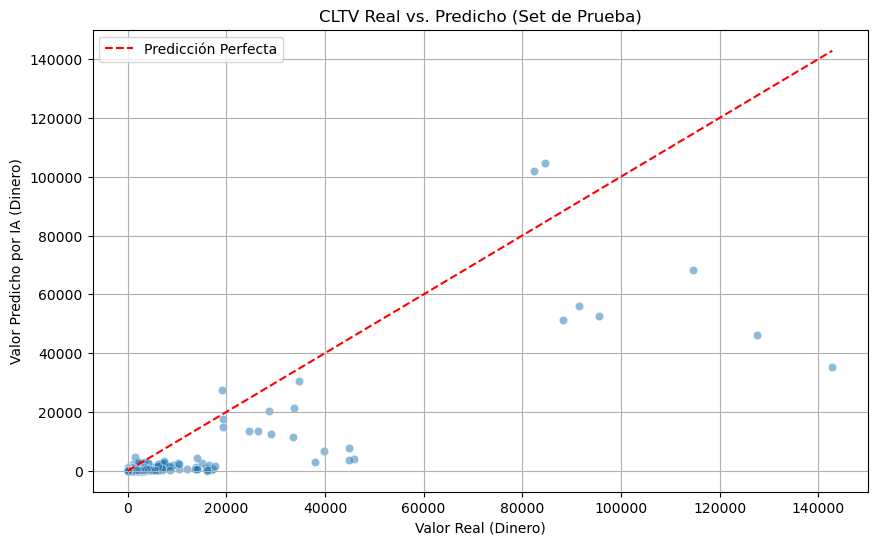

In [99]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_real, y=y_pred_real, alpha=0.5)

# Línea de perfección (Diagonal)
max_val = max(y_test_real.max(), y_pred_real.max())
plt.plot([0, max_val], [0, max_val], '--r', label='Predicción Perfecta')

plt.title('CLTV Real vs. Predicho (Set de Prueba)')
plt.xlabel('Valor Real (Dinero)')
plt.ylabel('Valor Predicho por IA (Dinero)')
plt.legend()
plt.grid(True)
plt.show()


El gráfico de dispersión evidencia una fuerte correlación lineal positiva, consistente con el $R^2$ de 0.62. Se observa una alta densidad de aciertos en el segmento de clientes estándar ($0 - $20k), donde el modelo muestra robustez.

Se detecta un fenómeno de subestimación en los clientes de alto valor (Outliers > $100k). El modelo tiende a ser conservador con los clientes con altos valores, prediciendo valores inferiores a los reales. Esto puede atribuirse a la escasez de datos en este rango, lo que limita la capacidad del modelo para aprender patrones precisos para estos casos atípicos.

## Top 5 Clientes con Mayor Valor Predicho

In [ ]:

# Usamos los test_ids que guardamos para filtrar el DF original
df_test_results = df_model_rolling[df_model_rolling['customer_id'].isin(test_ids)].copy()

# Nota: df_test_results puede tener más filas que y_pred_real si no filtramos exactamente igual que en el split.
# Para evitar errores de índice, lo más seguro es reconstruir un DF simple con las predicciones:

results_df = pd.DataFrame({
    'Real_CLTV': y_test_real,
    'Predicted_CLTV': y_pred_real,
    'Error_Absoluto': np.abs(y_test_real - y_pred_real)
})

# Añadimos una columna de "Segmento" basada en la predicción
results_df['Predicted_Segment'] = pd.qcut(results_df['Predicted_CLTV'], q=3, labels=['Bajo Valor', 'Medio Valor', 'Alto Valor'])

print("Top 5 Clientes con Mayor Valor Predicho:")
print(results_df.sort_values('Predicted_CLTV', ascending=False).head())

Top 5 Clientes con Mayor Valor Predicho:
          Real_CLTV  Predicted_CLTV  Error_Absoluto Predicted_Segment
438    84565.789062   104746.609375    20180.820312        Alto Valor
87     82413.773438   101938.523438    19524.750000        Alto Valor
467   114696.226562    68235.992188    46460.234375        Alto Valor
1164   91446.914062    56094.859375    35352.054688        Alto Valor
119    95594.242188    52502.503906    43091.738281        Alto Valor


# Conclusion del Modelo Realizado y Resultados Obtenidos

El modelo de Red Neuronal desarrollado para la predicción del Customer Lifetime Value (CLTV) alcanzó un Coeficiente de Determinación ($R^2$) de 0.62 en el conjunto de prueba. Este resultado indica que el modelo es capaz de explicar el 62% de la variabilidad del comportamiento de compra futuro de los clientes. Si bien demuestra una capacidad predictiva sólida para el cliente promedio, existen limitaciones estructurales derivadas de la disponibilidad de los datos que restringen su precisión en los segmentos de alto valor.

Factores Determinantes del Desempeño:
- Escasez de Histórico Temporal (Limitante Principal): El conjunto de datos abarca únicamente un año fiscal (Diciembre 2009 - Noviembre 2010). Para un problema de series temporales con estacionalidad, esto es insuficiente. El modelo no pudo aprender patrones cíclicos anuales completos (ej. no tiene con qué comparar la Navidad de 2009 vs. la de 2010), lo que limita su capacidad de generalización.

- Horizonte de Predicción vs. Ventana de Observación: Se estableció un objetivo ambicioso de predicción a 6 meses (horizonte) utilizando ventanas de observación cortas (3 meses) dentro de un dataset de solo 12 meses totales. La relación entre "historia disponible" y "futuro a predecir" es desproporcionada; predecir medio año de comportamiento basándose en un periodo tan corto de entrenamiento introduce una incertidumbre natural que el modelo no puede resolver sin más datos históricos.

- Subestimación en Valores Atípicos (Outliers): Como se evidenció en el análisis gráfico, el modelo presenta un sesgo de subestimación en clientes con compras inusualmente altas (ballenas/VIPs). Al utilizar una transformación logarítmica para normalizar la distribución, el modelo tiende a ser "conservador", ajustándose muy bien a la gran masa de clientes minoristas pero perdiendo sensibilidad ante los picos de facturación extremos que ocurren esporádicamente.


El modelo es apto para segmentación masiva y predicción de ingresos base, dado que captura correctamente la tendencia central de la mayoría de los clientes. Sin embargo, para una implementación productiva orientada a clientes VIP, se recomienda estrictamente aumentar la ventana histórica de recolección de datos a un mínimo de 24 meses para capturar ciclos completos y mitigar el impacto de la varianza en compras de alto valor.